In [34]:
# Data Processing
import pandas as pd
from PIL import Image
from examples.generator import generate_balanced_dataset, draw_circles, draw_rectangles
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_absolute_error

import torch
import torch.nn as nn
import torch.nn.functional as F

## Data Processing and Visualization

In [35]:
data, metadata = generate_balanced_dataset(100)

In [36]:
data = pd.DataFrame(data)

In [37]:
metadata = pd.DataFrame(metadata)

In [38]:
image_paths = [item for item in data[0]]
images = []

for path in image_paths:
    try:
        img = Image.open(path).convert('RGB')  # Convert to RGB to ensure consistency
        img = np.array(img)
        img_tensor = torch.tensor(img, dtype=torch.float32)  # Convert to PyTorch tensor
        images.append(img_tensor)
    except Exception as e:
        print(f"Error loading image {path}: {e}")

In [39]:
class EvalDataset(Dataset):
    def __init__(self, images, metadata):
        self.images = torch.stack([torch.tensor(image).permute(2, 0, 1) for image in images])
        self.metadata = torch.tensor(metadata).float()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        metadata = self.metadata[idx]
        return image, metadata
    
batch_size = 25

circle_metadata = metadata[["circle_center_x","circle_center_y", "circle_radius"]]

rectangle_metadata = metadata[["rect_tl_x",	"rect_tl_y"	,"rect_br_x"	,"rect_br_y"]]

train_images, test_images, train_circle_labels, test_circle_labels = train_test_split( images, circle_metadata.values, test_size=0.2, random_state=42)

train_images, test_images, train_rect_labels, test_rect_labels = train_test_split(images, rectangle_metadata.values, test_size=0.2, random_state=42)

# Create the training and test datasets for circles
train_circle_dataset = EvalDataset(train_images, train_circle_labels)
test_circle_dataset = EvalDataset(test_images, test_circle_labels)

# Create the training and test datasets for rectangles
train_rect_dataset = EvalDataset(train_images, train_rect_labels)
test_rect_dataset = EvalDataset(test_images, test_rect_labels)

# Create the dataloaders
batch_size = 25

# Circle dataloaders
train_circle_dataloader = DataLoader(train_circle_dataset, batch_size=batch_size, shuffle=True)
test_circle_dataloader = DataLoader(test_circle_dataset, batch_size=batch_size, shuffle=False)

# Rectangle dataloaders
train_rect_dataloader = DataLoader(train_rect_dataset, batch_size=batch_size, shuffle=True)
test_rect_dataloader = DataLoader(test_rect_dataset, batch_size=batch_size, shuffle=False)

/var/folders/mv/_dg3pqgn2zdf7f95_1dg07rw0000gn/T/ipykernel_71265/2891219731.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.images = torch.stack([torch.tensor(image).permute(2, 0, 1) for image in images])


# Models and Evaluation Functions

In [40]:
class CircleDetector(nn.Module):
    def __init__(self):
        super(CircleDetector, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(in_features=64*16*16, out_features=128)
        self.bn_fc1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(in_features=128, out_features=3)

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.leaky_relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = F.leaky_relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.leaky_relu(self.bn_fc1(self.fc1(x)))
        x = self.fc2(x)
        c_x, c_y, r = torch.sigmoid(x[:, 0]), torch.sigmoid(x[:, 1]), torch.sigmoid(x[:, 2])
        return c_x, c_y, r
class RectangleDetector(torch.nn.Module):
    def __init__(self):
        super(RectangleDetector, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(in_features=64*16*16, out_features=128)
        self.bn_fc1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(in_features=128, out_features=4)

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.leaky_relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = F.leaky_relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.leaky_relu(self.bn_fc1(self.fc1(x)))
        x = self.fc2(x)
        t_x, t_y,b_x, b_y = torch.sigmoid(x[:, 0]), torch.sigmoid(x[:, 1]), torch.sigmoid(x[:, 2]), torch.sigmoid(x[:, 3])
        return t_x, t_y, b_x, b_y

In [41]:
def train_circle(model, dataloader, criterion, optimizer, num_epochs=25, device='cpu'):
    model.to(device)
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            c_x, c_y, r = model(inputs)
            outputs = torch.stack((c_x, c_y, r), dim=1)
            
            # Calculate loss
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(dataloader.dataset)
        print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}')

def train_rect(model, dataloader, criterion, optimizer, num_epochs=25, device='cpu'):
    model.to(device)
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            tl_x, tl_y, br_x, br_y = model(inputs)
            outputs = torch.stack((tl_x, tl_y, br_x, br_y), dim=1)
            
            # Calculate loss
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(dataloader.dataset)
        print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}')


def evaluate_model_circle(model, dataloader, device='cpu'):
    model.to(device)
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            c_x, c_y, r = model(inputs)
            preds = torch.stack((c_x, c_y, r), dim=1)

            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    mae = mean_absolute_error(all_labels, all_preds)
    print(f'Mean Absolute Error: {mae:.4f}')
    return mae


def evaluate_model_rect(model, dataloader, device='cpu'):
    model.to(device)
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            tl_x, tl_y, br_x, br_y = model(inputs)
            preds = torch.stack((tl_x, tl_y, br_x, br_y), dim=1)

            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    mae = mean_absolute_error(all_labels, all_preds)
    print(f'Mean Absolute Error: {mae:.4f}')
    return mae


# Circle

In [42]:
circle = CircleDetector()
evaluate_model_circle(circle, test_circle_dataloader, device='cpu')
print()
train_circle(circle, train_circle_dataloader, nn.MSELoss(), torch.optim.Adam(circle.parameters()), num_epochs=20, device='cpu')
print()
evaluate_model_circle(circle, test_circle_dataloader, device='cpu')

Mean Absolute Error: 0.2129

Epoch 0/19, Loss: 0.0455
Epoch 1/19, Loss: 0.0144
Epoch 2/19, Loss: 0.0057
Epoch 3/19, Loss: 0.0025
Epoch 4/19, Loss: 0.0027
Epoch 5/19, Loss: 0.0018
Epoch 6/19, Loss: 0.0019
Epoch 7/19, Loss: 0.0010
Epoch 8/19, Loss: 0.0012
Epoch 9/19, Loss: 0.0026
Epoch 10/19, Loss: 0.0010
Epoch 11/19, Loss: 0.0014
Epoch 12/19, Loss: 0.0017
Epoch 13/19, Loss: 0.0015
Epoch 14/19, Loss: 0.0011
Epoch 15/19, Loss: 0.0010
Epoch 16/19, Loss: 0.0009
Epoch 17/19, Loss: 0.0013
Epoch 18/19, Loss: 0.0010
Epoch 19/19, Loss: 0.0006

Mean Absolute Error: 0.0196


np.float32(0.019637495)

In [43]:
test_data, test_metadata = next(iter(test_circle_dataloader))

In [44]:
circle.eval()
instance = test_data[1].unsqueeze(0)
c_x, c_y, r = circle(instance)

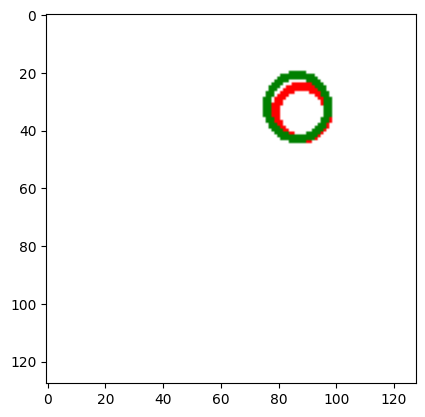

In [45]:
plt.imshow(draw_circles(*test_metadata[1], c_x, c_y, r))

# Rectangle

In [46]:
rect = RectangleDetector()
evaluate_model_rect(rect, train_rect_dataloader, device='cpu')
print()
train_rect(rect, train_rect_dataloader, nn.MSELoss(), torch.optim.Adam(rect.parameters()), num_epochs=20, device='cpu')
print()
evaluate_model_rect(rect, test_rect_dataloader, device='cpu')

Mean Absolute Error: 0.4679

Epoch 0/19, Loss: 0.0388
Epoch 1/19, Loss: 0.0068
Epoch 2/19, Loss: 0.0041
Epoch 3/19, Loss: 0.0033
Epoch 4/19, Loss: 0.0022
Epoch 5/19, Loss: 0.0025
Epoch 6/19, Loss: 0.0022
Epoch 7/19, Loss: 0.0021
Epoch 8/19, Loss: 0.0017
Epoch 9/19, Loss: 0.0017
Epoch 10/19, Loss: 0.0018
Epoch 11/19, Loss: 0.0013
Epoch 12/19, Loss: 0.0014
Epoch 13/19, Loss: 0.0019
Epoch 14/19, Loss: 0.0011
Epoch 15/19, Loss: 0.0014
Epoch 16/19, Loss: 0.0018
Epoch 17/19, Loss: 0.0013
Epoch 18/19, Loss: 0.0018
Epoch 19/19, Loss: 0.0011

Mean Absolute Error: 0.0280


np.float32(0.02798656)

In [47]:
test_data, test_metadata = next(iter(test_rect_dataloader))

In [48]:
rect.eval()
instance = test_data[2].unsqueeze(0)
t_x, t_y, b_x, b_y = rect(instance)

tensor(28.) tensor(71.) tensor(72.) tensor(115.)
tensor([25.2425], grad_fn=<MulBackward0>) tensor([74.4211], grad_fn=<MulBackward0>) tensor([70.4309], grad_fn=<MulBackward0>) tensor([117.8755], grad_fn=<MulBackward0>)


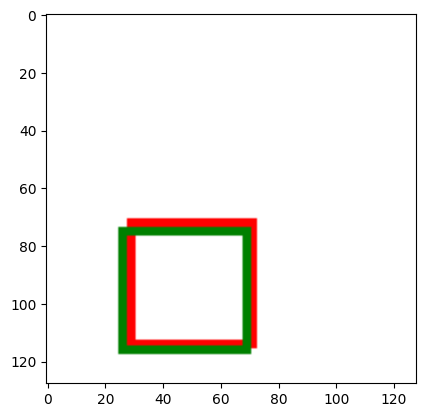

In [49]:
plt.imshow(draw_rectangles(*test_metadata[2], t_x, t_y, b_x, b_y))